In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from scipy.integrate import simpson
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import join as pjoin
sns.set_style('whitegrid')
sns.set_context('talk')

In [146]:
LOSSFIELD = "structural_mean"
LOSSFIELD2 = "structural_loss_sum"
BASEPATH = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\impact\AEP\20231206_run_1\ACT"
OUTPATH = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\impact\AAL\20231206_run_1\ACT"
state_name = "ACT"
ARIS = os.listdir(BASEPATH)
ARIS = ([s.replace('_agg', '') for s in ARIS])
ARIS = [sub[: -4] for sub in ARIS]
ARIS = [sub[2:] for sub in ARIS]
ARIS = list(dict.fromkeys(ARIS))

In [147]:
ARIS = list(map(int, ARIS))
ARIS = sorted(ARIS)
__eps__ = 1.0e-6
lossdf = pd.DataFrame(columns=["SA1_CODE", *ARIS])
lossdf2 = pd.DataFrame(columns=["SA1_CODE", *ARIS])

In [148]:
# calculating aep (probability) from ari (average recurrence)
def probability(ari):
    """Return an annual probability given a return period"""
    aep = 1.0 - np.exp(-1.0/ari)
    return aep


In [149]:
#AAL stats
def AAL_loss_stats(df,state_name,lossfield,outpath):
    Max = df['AAL'].max()
    Min = df['AAL'].min()
    Mean = df['AAL'].mean()
    Median = df['AAL'].median()
    Std = df['AAL'].std()
    loss_stats = pd.DataFrame({"Dataset": [f"{LOSSFIELD}_{state_name}"],
                               "Max": [Max],
                               "Min": [Min],
                               "Mean": [Mean],
                               "Median": [Median],
                               "Std": [Std]})
    loss_stats.set_index("Dataset", inplace=True)
    loss_stats.to_csv(pjoin(outpath,
                    f"{lossfield}_{state_name}_AAL_loss_stats.csv"))

# defining functions for plots

def plotaal_count_ratio(df,state_name,lossfield,outpath,type):
    med_loss = df['AAL'].median()
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(df['AAL'], ax=ax)
    plt.xlim([0,0.00015])
    ax.set_yscale('log')
    ax.set_xlabel('AAL')
    ax.set_ylabel('Count')
    plt.axvline(med_loss, color='k', linestyle='dashed', linewidth=1.5)
    ax.set_title(state_name)
    plt.savefig(pjoin(outpath, type,
                    f"{lossfield}_{state_name}_AAL.png"))

def plotaal_count_loss(df,state_name,lossfield,outpath,type):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(df['AAL'], ax=ax)
    plt.xlim(left=0)
    ax.set_yscale('log')
    ax.set_xlabel('AAL (Millions)')
    ax.set_ylabel('Count')
    ax.set_title(state_name)
    plt.savefig(pjoin(outpath, type,
                    f"{lossfield}_{state_name}_AAL.png"))

In [150]:
                  
#for structural loss ratio
def plotaal_prob_ratio(df,state_name,lossfield,outpath,type):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x=df, y=aeps, ax=ax)
    ax.set_yscale('log')
    plt.xlim([0,0.55])
    plt.ylim(bottom=0.0001)
    ax.set_xlabel('Structural Loss Ratio')
    ax.set_ylabel('Annual Exceedance Probability')
    ax.set_title(state_name)
    ax.fill_between(df, aeps, alpha=0.2)
    plt.savefig(pjoin(outpath, type,
                    f"{lossfield}_{state_name}_probability_loss.png"))

# for structural loss (cost)
def plotaal_prob_loss(df,state_name,lossfield,outpath,type):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x=df, y=aeps, ax=ax)
    ax.set_yscale('log')
    plt.xlim([0,95])
    plt.ylim(bottom=0.0001)
    ax.set_xlabel('Structural Loss Value (Billions)')
    ax.set_ylabel('Annual Exceedance Probability')
    ax.fill_between(df, aeps, alpha=0.2)
    ax.set_title(state_name)
    plt.savefig(pjoin(outpath, type,
                    f"{lossfield}_{state_name}_probability_loss.png"))

Structural loss ratio

In [151]:
# setting SA1 code for loss dataframe
firstdf = pd.read_csv(os.path.join(BASEPATH, f"RP1_agg.csv"))
lossdf['SA1_CODE'] = firstdf['SA1_CODE']
lossdf.set_index('SA1_CODE', inplace=True)

In [152]:
# importing all ari output flies
for ARI in ARIS:
    if ARI == 1: continue
    tmpdf = pd.read_csv(os.path.join(BASEPATH, f"RP{ARI:d}_agg.csv"))
    tmpdf.set_index('SA1_CODE', inplace=True)
    lossdf = lossdf.join(tmpdf[LOSSFIELD])
    lossdf[ARI] = lossdf[LOSSFIELD]
    lossdf.drop(LOSSFIELD, axis=1, inplace=True)
lossdf[1] = 0

In [153]:
# calculating average annualised loss
aeps = probability(np.array(lossdf.columns.to_list()))
lossdf['AAL'] = (lossdf).apply(simpson, axis=1, x=-1*aeps)
lossdf.to_csv(pjoin(OUTPATH, f"{LOSSFIELD}_{state_name}_SA1.csv"))
aeps_save = pd.DataFrame(aeps)
aeps_save.to_csv(pjoin(OUTPATH, f"{LOSSFIELD}_{state_name}_aeps.csv"))
lossdf_stats = AAL_loss_stats(lossdf,state_name,LOSSFIELD,OUTPATH)

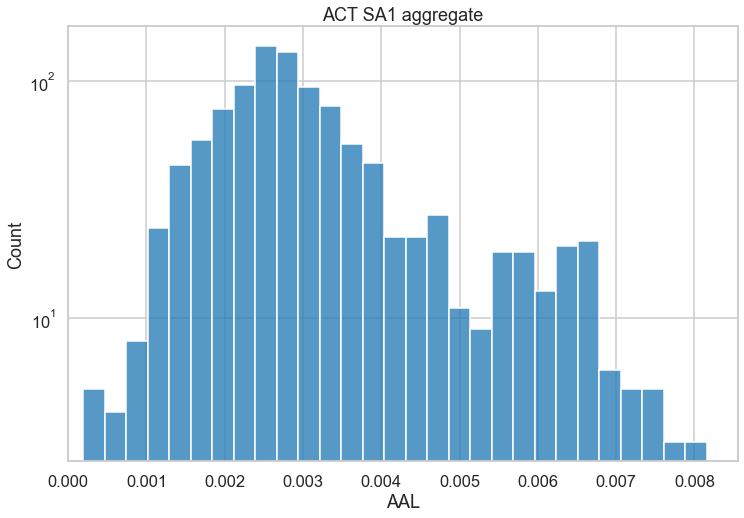

In [154]:
# plotting count against AAL (structural loss ratio)
# SA1 agg
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(lossdf['AAL'], ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
ax.set_xlabel('AAL')
ax.set_ylabel('Count')
ax.set_title(f'{state_name} SA1 aggregate')
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD}_{state_name}_SA1"))

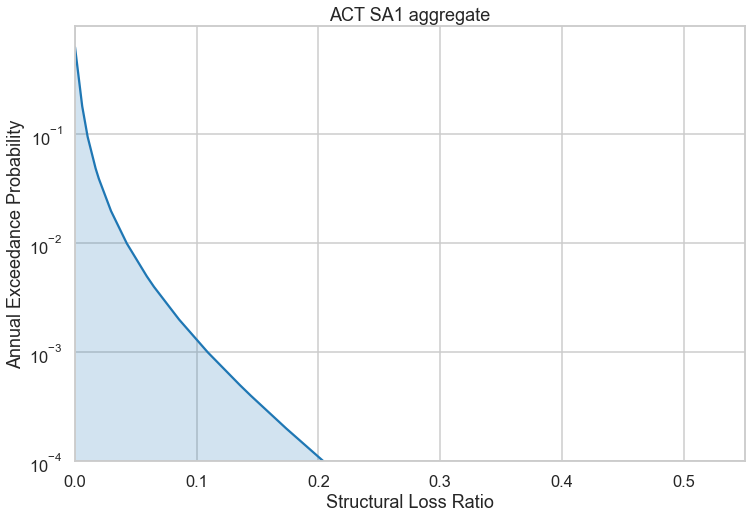

In [155]:
# finding mean of structural loss ratio mean
# to create AAL prob plot
# SA1 agg
lossdf = lossdf.drop(['AAL'], axis=1)
lossdf = lossdf.mean(axis=0)


# creating AAL prob plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=lossdf, y=aeps, ax=ax)
ax.set_yscale('log')
plt.xlim([0,0.55])
plt.ylim(bottom=0.0001)
ax.set_xlabel('Structural Loss Ratio')
ax.set_ylabel('Annual Exceedance Probability')
ax.set_title(f'{state_name} SA1 aggregate')
ax.fill_between(lossdf, aeps, alpha=0.2)
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD}_{state_name}_SA1_probability_loss"))

Structural loss

In [156]:
firstdf2 = firstdf
lossdf2['SA1_CODE'] = firstdf2['SA1_CODE']
lossdf2.set_index('SA1_CODE', inplace=True)

In [157]:
for ARI in ARIS:
    if ARI == 1: continue
    tmpdf2 = pd.read_csv(os.path.join(BASEPATH, f"RP{ARI:d}_agg.csv"))
    tmpdf2.set_index('SA1_CODE', inplace=True)
    lossdf2 = lossdf2.join(tmpdf2[LOSSFIELD2])
    lossdf2[ARI] = lossdf2[LOSSFIELD2]
    lossdf2.drop(LOSSFIELD2, axis=1, inplace=True)
lossdf2[1] = 0

In [158]:
aeps = probability(np.array(lossdf2.columns.to_list()))
lossdf2['AAL'] = lossdf2.apply(simpson, axis=1, x=-1*aeps)
lossdf2.to_csv(pjoin(OUTPATH, f"{LOSSFIELD2}_{state_name}_SA1.csv"))
lossdf2 = lossdf2.div(1000000)
lossdf2_stats = AAL_loss_stats(lossdf2,state_name,LOSSFIELD2,OUTPATH)

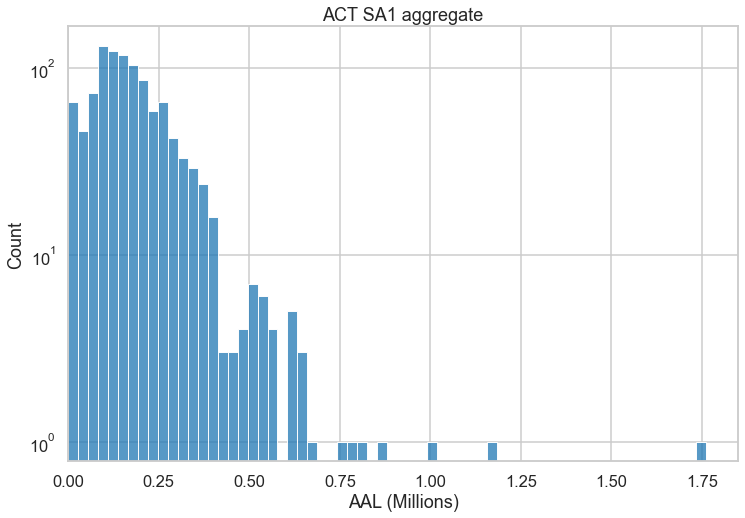

In [159]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(lossdf2['AAL'], ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
ax.set_xlabel('AAL (Millions)')
ax.set_ylabel('Count')
ax.set_title(f'{state_name} SA1 aggregate')
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD2}_{state_name}_SA1"))

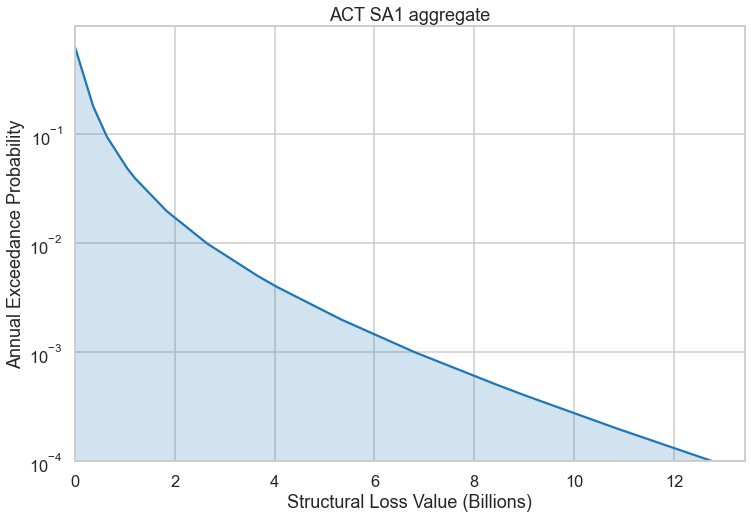

In [160]:
lossdf2 = lossdf2.drop(['AAL'], axis=1)
lossdf2 = lossdf2.sum(axis=0)
lossdf2 = lossdf2.div(1000)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=lossdf2, y=aeps, ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
plt.ylim(bottom=0.0001)
ax.set_xlabel('Structural Loss Value (Billions)')
ax.set_ylabel('Annual Exceedance Probability')
ax.set_title(f'{state_name} SA1 aggregate')
ax.fill_between(lossdf2, aeps, alpha=0.2)
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD2}_SA1_probability_loss"))